In [1]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno
import datetime,gc,math
import random
import lightgbm as lgb
from sklearn.model_selection import KFold, train_test_split
from sklearn.preprocessing import LabelEncoder, OneHotEncoder,MinMaxScaler, StandardScaler
from sklearn.metrics import recall_score, auc, accuracy_score, f1_score, precision_score, classification_report, roc_auc_score,mean_squared_error
from pandas.api.types import is_categorical_dtype
from pandas.api.types import is_datetime64_any_dtype as is_datetime
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error
%matplotlib inline

In [2]:
def active_time_transform(df):
    df['role_created_active_time'].fillna('"0-8,0","8-12,0","12-14,0","14-18,0","18-24,0"', inplace=True)
    df['role_created_active_time'] = df['role_created_active_time'].apply(lambda x:str(x)[1:-1])
    temp = df['role_created_active_time'].str.split(',',expand=True).iloc[:,[1,3,5,7,9]].rename(columns={1:'active_0-8',
                                        3:'active_8-12',5:'active_12-14',7:'active_14-18',9:'active_18-24'})
    for i in range(len(temp.columns)):
        temp.iloc[:,i] = temp.iloc[:,i].apply(lambda x:str(x)[:-1])
    df = df.join(temp).drop(['role_created_active_time'], axis=1)
    return df

def pay_grade_transform(df):
    df['pay_grade'].fillna('[0,0,0,0,0,0,0]',inplace=True)
    df['pay_grade'] = df['pay_grade'].apply(lambda x:str(x)[1:-1])
    temp = df['pay_grade'].str.split(',',expand=True).rename(columns={0:'pay_grade_1',
                1:'pay_grade_2',2:'pay_grade_3',3:'pay_grade_4',4:'pay_grade_5',5:'pay_grade_6',6:'pay_grade_7'})
    df = df.join(temp).drop(['pay_grade'], axis=1)
    return df

In [3]:
%%time
role_info = pd.read_csv('./data/mr_role_6d.csv')
role_info.drop_duplicates(subset=['user_id','cp_server_no','cp_role_id'],inplace=True)
role_info = active_time_transform(role_info)
role_info = pay_grade_transform(role_info)
role_info.to_pickle('./role_info_6d.pickle')

Wall time: 1min 44s


In [4]:
# role_info = pd.read_pickle('./role_info_6d.pickle')
# 删除2020-7-19日前30天的数据
role_info['create_role_time'] = pd.to_datetime(role_info['create_role_time'], format='%Y-%m-%d %H:%M:%S')
role_info.drop(role_info[role_info['create_role_time'] > (role_info['create_role_time'].max() + 
                                                          datetime.timedelta(-30))].index,inplace=True)

In [5]:
# 删除没有心跳数据的样本(1、没有登录;2、没有拿到心跳)
role_info.dropna(subset=['role_created_login_num'], inplace=True)
role_info.dropna(subset=['role_created_online'], inplace=True)
role_info['pay_num'].fillna(0, inplace=True)
role_info['pay_sum'].fillna(0, inplace=True)
role_info['role_created_active'] = role_info['role_created_active'].clip(0,6)
role_info['pay_rate'] = role_info['pay_num'] / (role_info['role_created_active'] + 1e-4)
role_info['pay_avg'] = role_info['pay_sum'] / (role_info['pay_num'] + 1e-4)

In [6]:
# 清洗设备金额
role_info.loc[role_info['p_model'] == 'iPhone 6s Plus','model_money'] = 3500
role_info.loc[role_info['p_model'] == 'iPhone12,1','model_money'] = 5000
role_info.loc[role_info['p_model'] == 'iPhone12,1','model_money'] = 2500
role_info.loc[role_info['p_model'] == 'iPhone12,1','model_money'] = 2000
role_info['model_money'] = role_info['model_money'].replace(0, np.nan)
role_info['model_money'].fillna(role_info[role_info['model_money'] !=0]['model_money'].mean(),inplace=True)
bins=[0,1000,1500,2000,2500,3000,3500,4000,4500,5000,6000,8000,10000]
role_info['model_money_level'] = pd.cut(role_info['model_money'],bins,labels=False)

In [7]:
# 清洗login_num
# 截取3登陆次数大于200的样本
role_info['role_created_login_num'].clip(1,200,inplace=True)
tmp = role_info[role_info['role_created_login_num'] <3]
tmp['role_created_login_num'] = tmp['max_role_level'] * (
            role_info['role_created_login_num'].mean()/role_info['max_role_level'].mean())
role_info['role_created_login_num'].update(tmp['role_created_login_num'])
role_info['role_created_login_num'].clip(1,200,inplace=True)

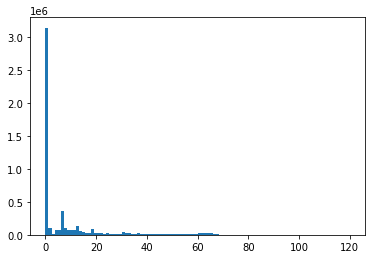

In [8]:
plt.hist(role_info['max_role_level'],bins=100,range=(0,120))
plt.show()

In [9]:
# 清洗max_role_level
# 按前6天在线时长更新等级小于5级的
tmp = role_info[role_info['max_role_level'] <5]
tmp['max_role_level'] = tmp['role_created_online'] * (
    role_info['max_role_level'].mean()/role_info['role_created_online'].mean())
role_info['max_role_level'].update(tmp['max_role_level'])
# 截取等级大于100级的
role_info['max_role_level'].clip(1,100,inplace=True)

In [10]:
# 清洗online
# 按等级补全在线时长
tmp = role_info[role_info['role_created_online'] <1800]
tmp['role_created_online'] = tmp['max_role_level'] * (role_info['role_created_online'].mean()/role_info['max_role_level'].mean())
role_info['role_created_online'].update(tmp['role_created_online'])
# 截断 最小5分钟，最大48小时
role_info['role_created_online'].clip(300,172800,inplace=True)

In [11]:
# 处理时间特征create_role_time
role_info = role_info.sort_values('create_role_time').reset_index(drop=True)
role_info['hour'] = role_info['create_role_time'].dt.hour
role_info['weekend'] = role_info['create_role_time'].dt.weekday
holidays = ['2019-09-13','2019-09-14','2019-09-15','2019-10-01','2019-10-02','2019-10-03','2019-10-04','2019-10-05','2019-10-06','2019-10-07',
            '2020-01-01','2020-01-24','2020-01-25','2020-01-26','2020-01-27','2020-01-28','2020-01-29','2020-01-30','2020-04-04','2020-04-05',
            '2020-04-06','2020-04-04','2020-05-01','2020-05-02','2020-05-03','2020-05-04','2020-05-05','2020-06-25','2020-06-27']
role_info['timestamp'] = role_info['create_role_time'].dt.date.apply(lambda x:str(x))
role_info['is_holidays'] = (role_info['timestamp'].isin(holidays)).astype(int)
role_info.drop(['timestamp'], axis=1, inplace=True)

In [12]:
# 合并role_user
user_info = pd.read_csv('./user_info.csv')
user_info.drop_duplicates(inplace=True)
data = pd.merge(role_info,user_info,on='user_id',how='left',validate='many_to_one')
# 标记用户时否绑定了手机，绑定;1    未绑定：0
data['mobile'] = pd.to_numeric(data['mobile'],errors='coerce')
data['mobile'] = data['mobile'].apply(lambda x:0 if np.isnan(x) == True else 1)
# 用户注册时间与角色注册时间的时间差,并进行分桶
data['reg_date'] = pd.to_datetime(data['reg_date'])
data['time_interval'] = (data['create_role_time'] - data['reg_date']).dt.total_seconds()/3600
data['time_interval'] = data['time_interval'].clip(0,2000)
data['time_interval'] = pd.cut(data['time_interval'], bins=[0,1,3,12,24,72,168,720,2000],labels=False)

data['active_0-8'] = pd.to_numeric(data['active_0-8'], errors='coerce')
data['active_8-12'] = pd.to_numeric(data['active_8-12'], errors='coerce')
data['active_12-14'] = pd.to_numeric(data['active_12-14'], errors='coerce')
data['active_14-18'] = pd.to_numeric(data['active_14-18'], errors='coerce')
data['active_18-24'] = pd.to_numeric(data['active_18-24'], errors='coerce')

In [13]:
data['pay_grade_1'] = pd.to_numeric(data['pay_grade_1'], errors='coerce')
data['pay_grade_2'] = pd.to_numeric(data['pay_grade_2'], errors='coerce')
data['pay_grade_3'] = pd.to_numeric(data['pay_grade_3'], errors='coerce')
data['pay_grade_4'] = pd.to_numeric(data['pay_grade_4'], errors='coerce')
data['pay_grade_5'] = pd.to_numeric(data['pay_grade_5'], errors='coerce')
data['pay_grade_6'] = pd.to_numeric(data['pay_grade_6'], errors='coerce')
data['pay_grade_7'] = pd.to_numeric(data['pay_grade_7'], errors='coerce')
role_created_30_pay_sum = pd.read_csv('./data/role_created_30_pay_sum.csv',index_col=0)
# 对连接的关键字进行字符化或者整型化的调整
role_created_30_pay_sum['user_id'] = role_created_30_pay_sum['user_id'].astype(str)
role_created_30_pay_sum['mgame_id'] = role_created_30_pay_sum['mgame_id'].astype(str)
role_created_30_pay_sum['cp_server_no'] = role_created_30_pay_sum['cp_server_no'].astype(str)
role_created_30_pay_sum['cp_role_id'] = role_created_30_pay_sum['cp_role_id'].astype(str)
data['user_id'] = data['user_id'].astype(str)
data['mgame_id'] = data['mgame_id'].astype(str)
data['cp_server_no'] = data['cp_server_no'].astype(str)
data['cp_role_id'] = data['cp_role_id'].astype(str)
role_created_30_pay_sum.drop_duplicates(subset=['user_id','cp_server_no','mgame_id','cp_role_id'],inplace=True)
data.drop_duplicates(subset=['user_id','cp_server_no','mgame_id','cp_role_id'],inplace=True)
data = pd.merge(data,role_created_30_pay_sum,on=['user_id','mgame_id','cp_server_no','cp_role_id'],how='left',validate='one_to_one')

In [14]:
data.to_pickle('./data_6d.pickle')
del role_info,tmp,data,role_created_30_pay_sum,user_info
gc.collect()

9181